# Imports + GPU Setup

In [26]:
import os

os.environ["WANDB_DISABLED"] = "true"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
os.environ["TOKENIZERS_PARALLELISM"] = "false"


import pandas as pd
import numpy as np
import torch
import logging
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import seaborn as sns


from simpletransformers.classification import ClassificationModel, ClassificationArgs

from preprocessing import load_data, preprocess_data

logging.basicConfig(level=logging.ERROR)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'device: {device}')



device: cuda


In [4]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU detected")

True
1
Tesla V100S-PCIE-32GB


# Data Setup

Retrieves the data, applies the specified train and test split to organise data into **train_df** and **dev_df**.

In [5]:
train_df, dev_df, test_df = load_data()

# Dataset

In [6]:
processed_train_df = preprocess_data(train_df, clean_data=False, add_country=False, add_community=True)
processed_dev_df = preprocess_data(dev_df, clean_data=False, add_country=False, add_community=True)
processed_test_df = preprocess_data(test_df, clean_data=False, add_country=False, add_community=True)

In [7]:
processed_test_df

,par_id,country,text,community
0,t_0,us,"vulnerable , In the meantime , conservatives a...",vulnerable
1,t_1,pk,"women , In most poor households with no educat...",women
2,t_2,ca,"migrant , The real question is not whether imm...",migrant
3,t_3,gb,"migrant , In total , the country 's immigrant ...",migrant
4,t_4,ca,"vulnerable , Members of the church , which is ...",vulnerable
...,...,...,...,...
3827,t_3893,jm,"migrant , In a letter dated Thursday to Europe...",migrant
3828,t_3894,au,"poor-families , They discovered that poor fami...",poor-families
3829,t_3895,ca,"migrant , She married at 19 , to Milan ( Emil ...",migrant
3830,t_3896,us,"immigrant , The United Kingdom is n't going to...",immigrant


# TRAINING

In [8]:
def set_seed(i):
    torch.manual_seed(i)
    np.random.seed(i)

In [9]:
class EnsembleClassifier:
    def __init__(self, models_list):
        task1_model_args = ClassificationArgs(
            num_train_epochs=5,
            no_save=False,          # Allows saving
            no_cache=True,
            overwrite_output_dir=True,
            train_batch_size=16,
            learning_rate=1e-5,
            output_dir='saved_model',
            save_model_every_epoch=False,
            save_steps=-1,          # Disable intermediate saves
            use_multiprocessing= False, 
            use_multiprocessing_for_evaluation=False,
            process_count= 1,
        )
        self.models = []
        for model_file in models_list:
            model = ClassificationModel(
                'roberta',
                f"saved_models/{model_file}",
                args=task1_model_args,
            )
            self.models.append(model)
    
    def predict(self, text_list):
        preds = []
        outputs = []
        for model in self.models:
            pred, output = model.predict(text_list)
            preds.append(pred)
            outputs.append(output)
        
        preds = np.array(preds)
        outputs = np.array(outputs)

        majority_pred = np.mean(preds, axis=0) >= 0.5
        soft_pred = np.mean(outputs, axis=0)
        soft_pred = np.argmax(soft_pred, axis=-1)
        return majority_pred.astype(int), soft_pred.astype(int)






In [10]:
saved_models = [
    "model-large-2",
    "model-large-5",
    "model-large-nwrs-0",
    "model-large-nwrs-1",
    "model-large-nwrs-2"
]

In [11]:
model = EnsembleClassifier(models_list=saved_models)

In [12]:
hard_pred, soft_pred = model.predict(processed_dev_df["text"].tolist())

  0%|          | 0/21 [00:00<?, ?it/s]

/home/infres/hverninas-22/miniconda3/lib/python3.12/site-packages/simpletransformers/classification/classification_model.py:2188: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

In [13]:
wrong_preds = hard_pred != processed_dev_df["label"]

In [15]:
df_wrong_preds = dev_df.loc[wrong_preds]

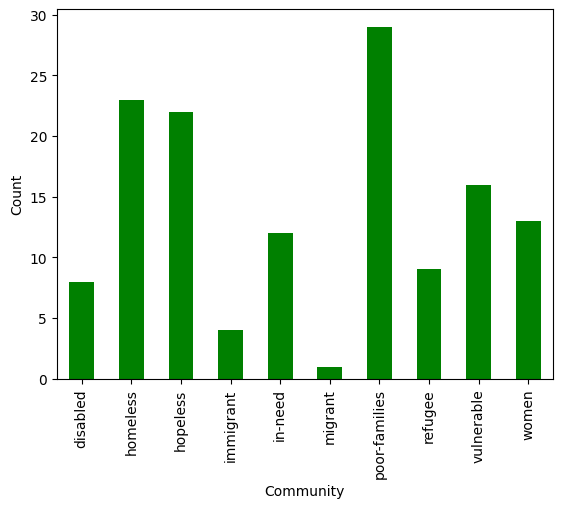

In [20]:
df_wrong_preds["community"].value_counts().sort_index().plot(kind='bar', color='green')
# plt.title('Community Distribution of Wrong Predictions for Dev set')
plt.xlabel('Community')
plt.ylabel('Count')

plt.show()

In [30]:
df_wrong_preds

,par_id,community,country,text,label,length
0,4046,hopeless,us,We also know that they can benefit by receivin...,1,493
2,8330,refugee,ng,Many refugees do n't want to be resettled anyw...,1,74
4,4089,homeless,pk,"""In a 90-degree view of his constituency , one...",1,355
5,432,refugee,nz,He depicts demonstrations by refugees at the b...,1,229
8,2001,poor-families,tz,t is remiss not to mention here that not all s...,1,161
...,...,...,...,...,...,...
1852,10200,refugee,in,She also praised the efforts to stabilise the ...,0,376
1881,10230,poor-families,au,Delhi : Going on stage at school and acting ou...,0,274
1907,10260,homeless,za,""""""" Not homeless -- but STARVING for success ....",0,195
1923,10277,disabled,ng,""""""" This definitive outcome is a testament to ...",0,293


In [23]:
df_wrong_preds = df_wrong_preds.copy()
df_wrong_preds["length"] = df_wrong_preds["text"].apply(lambda x: len(x))

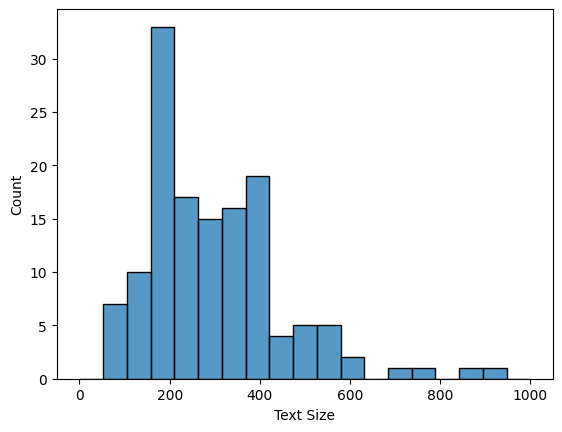

In [29]:
bins = np.linspace(0,1000,20)
sns.histplot(df_wrong_preds['length'], bins=bins, kde=False)
plt.xlabel('Text Size')
plt.ylabel('Count')
plt.show()

In [ ]:
with open("wrongs_preds.txt","w") as f:
    for i,row in dev_df.loc[wrong_preds].iterrows():
        f.write(f"{row.community} ({row.label}) : {row.text}\n")

In [14]:
print("f1 hard:", f1_score(processed_dev_df["label"].tolist(),hard_pred))
print("f1 soft:", f1_score(processed_dev_df["label"].tolist(),soft_pred))

f1 hard: 0.6404199475065617
f1 soft: 0.6266318537859008


In [46]:
with open("dev_set_predictions.txt", "w") as f:
    for x in hard_pred:
        f.write(str(x)+'\n')

In [39]:
hard_pred, soft_pred = model.predict(processed_test_df["text"].tolist())

  0%|          | 0/39 [00:00<?, ?it/s]

/home/infres/hverninas-22/miniconda3/lib/python3.12/site-packages/simpletransformers/classification/classification_model.py:2188: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

In [41]:
with open("test_set_predictions.txt", "w") as f:
    for x in hard_pred:
        f.write(str(x)+'\n')